In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import concatenate, Dense, Input, Flatten
from keras.optimizers import *
import sys
sys.path.append('../module/')
import gym2
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory

/Users/admin/.pyenv/versions/3.7.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/admin/.pyenv/versions/3.7.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/admin/.pyenv/versions/3.7.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/admin/.pyenv/versions/3.7.4/lib/python3

In [2]:
# GymのPendulum環境を作成
dt = 0.005
env = gym2.make("Pendulum-v1", dt)
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(a_shape[0], activation="linear")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape, s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(32, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def rlagent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = DDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        target_model_update=.01
    )
    return agent

In [10]:
agent = rlagent(env.action_space.shape, (2,))

opt = 'adam'

if opt == 'adam':
    #adam optimizer
    agent.compile(Adam(lr=0.001, clipnorm=1., decay = 0.0001), metrics=["mse"])
elif opt == 'adadelta':
    #adadelta optimizer
    agent.compile(Adadelta(), metrics=['mse'])
elif opt == 'adagrad':
    #adagrad optimizer
    agent.compile(Adagrad(), metrics=['mse'])
else:
    assert False, 'Fuck'

agent.fit(env, nb_steps=50000, visualize=0, verbose=1, nb_max_episode_steps=2000)
#agent.test(env, nb_episodes=5, visualize=0, nb_max_episode_steps=200)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 64s 6ms/step - reward: -8.3933
5 episodes - episode_reward: -16786.610 [-19772.372, -13061.309] - loss: 37.513 - mean_squared_error: 75.025 - mean_q: -260.750

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 68s 7ms/step - reward: -5.9990
5 episodes - episode_reward: -11998.001 [-17080.086, -5238.341] - loss: 93.243 - mean_squared_error: 186.486 - mean_q: -405.919

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 64s 6ms/step - reward: -2.2760
5 episodes - episode_reward: -4551.993 [-5092.869, -3521.289] - loss: 107.681 - mean_squared_error: 215.361 - mean_q: -435.725

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 67s 7ms/step - reward: -2.7665
5 episodes - episode_reward: -5532.959 [-14918.979, -2531.027] - loss: 84.889 - mean_squared_error: 169.778 - mean_q: -410.804

Interval 

In [12]:
agent.test(env, nb_episodes=5, visualize=1, nb_max_episode_steps=2000)

Testing for 5 episodes ...
Episode 1: reward: -629.373, steps: 2000
Episode 2: reward: -474.705, steps: 2000
Episode 3: reward: -378.572, steps: 2000
Episode 4: reward: -343.384, steps: 2000
Episode 5: reward: -388.033, steps: 2000


Testing for 5 episodes ...


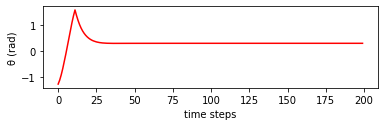

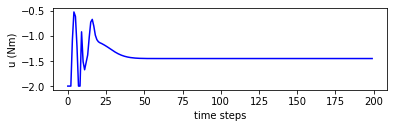

Episode 1: reward: -133.819, steps: 200


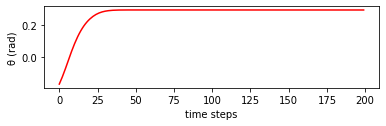

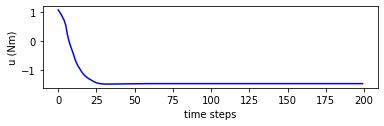

Episode 2: reward: -20.138, steps: 200


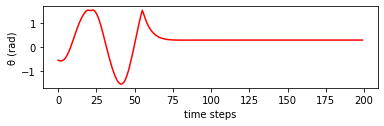

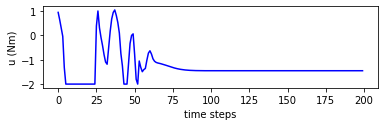

Episode 3: reward: -399.076, steps: 200


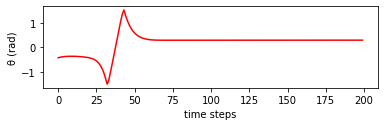

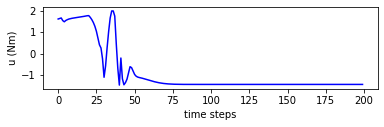

Episode 4: reward: -146.608, steps: 200


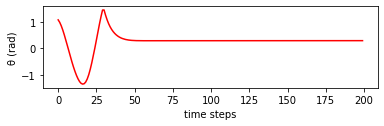

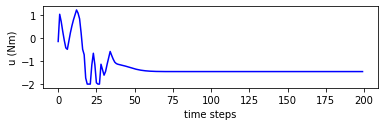

Episode 5: reward: -252.548, steps: 200


In [8]:
def rlagent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = DDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        target_model_update=.01
    )
    return agent

agent =  rlagent((1,), env.observation_space.shape)
agent.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mse"])
agent.load_weights('./testview.h5')
agent.test(env, nb_episodes=5, visualize=1, nb_max_episode_steps=200, graph=1)

In [ ]:
agent.fit(env, nb_steps=30000, visualize=1, verbose=1, nb_max_episode_steps=200)

In [12]:
agent.save_weights('testview.h5')